In [2]:
# Thoomas Goldman 2023
# DOLPHINN
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle 

#Get the absolute path of the current scriptf
current_path = os.path.dirname(os.path.abspath('__file__'))
dolphinn_path = os.path.join(current_path, '..')
sys.path.append(dolphinn_path)

from DOLPHINN.pinn import DOLPHINN 
from DOLPHINN.training import Scheduler, Restarter, Restorer
from DOLPHINN.metrics import FinalDr, FinalDv
from DOLPHINN.callbacks import StoreAnimationData
from DOLPHINN import plotting
from DOLPHINN import utils

In [51]:
mu = 1.32712440042e20 # SUN
m = 100 #Spacecraft mass
AU = 1.5e11 #EARTH-SUN
a = 10

rp = AU
ra = 2*AU

e = (ra - rp)/(ra + rp)
sma = (rp + ra)/2

# Initial state
r0 = AU
vr0 = 0
vt0 = np.sqrt(1+e)*np.sqrt(mu/r0) 
initial_state = np.array([r0, vr0, vt0])

# Non dimensionalize
length_scale = AU
time_scale = AU / vt0

initial_state[:1] = initial_state[:1]/length_scale
initial_state[1:] = initial_state[1:]*time_scale/length_scale

# Integration times
period = 2*np.pi*np.sqrt(sma**3/mu)
t0 = 0
tfinal = 1*period
N = 200

# Network architecture
input_dimension = 1
output_dimension = 3
neurons = 3
hidden_layers = 3
layer_size = [input_dimension] + [[neurons]*output_dimension] * hidden_layers + [output_dimension]
#layer_size = [1] + [10] + [3]
        
data = {"initial_state": initial_state,
        "mu": mu,
        "m": m,
        "a": a,
        "length_scale": length_scale,
        "time_scale": time_scale,
        "t0": t0,
        "tfinal": tfinal/time_scale,
        "architecture": layer_size,
        "activation": "sin",
        "N_train": N,
        "N_boundary": 2,
        "N_test": N,
        "sampler": "perturbed_uniform_tf"}
print(e) 

0.3333333333333333


In [52]:
print(sma/AU)

1.5


In [53]:
# Create problem
problem = DOLPHINN(data,
                    "TwoBodyProblemRadialNonDimensional",
                    output_transform = "InitialStateLayer", 
                    display_every = 1000)
restarter = Restarter([(1e-2, 1000)])
schedule = Scheduler([(1e-3, 8000), (1e-4, 5000)])
problem.train([restarter, schedule])

[DOLPHINN] Using time-dependent random seed: 20230718140022

[DOLPHINN] Training with procedure: Restarter

[RESTARTER] Initialisation attempt: 1
Compiling model...
'compile' took 0.001626 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.31e-01, 2.92e+04, 8.66e-01]    [7.36e-01, 2.97e+04, 8.66e-01]    []  
1000      [4.27e-02, 3.73e-02, 2.89e-02]    [4.30e-02, 3.78e-02, 2.92e-02]    []  

Best model at step 1000:
  train loss: 1.09e-01
  test loss: 1.10e-01
  test metric: []

'train' took 4.668359 s


[DOLPHINN] Training with procedure: Scheduler

Compiling model...
'compile' took 0.044882 s

Training model...

Step      Train loss                        Test loss                         Test metric
1000      [4.27e-02, 3.73e-02, 2.89e-02]    [4.30e-02, 3.78e-02, 2.92e-02]    []  
2000      [2.25e-04, 1.97e-04, 4.10e-04]    [2.16e-04, 1.91e-04, 4.13e-04]    []  
3000      [7.97e-05, 6.96e-05, 2.24e-04]    [7.77

In [54]:
schedule = Scheduler([(1e-4, 10000)])
problem.train([schedule])


[DOLPHINN] Training with procedure: Scheduler

Compiling model...
'compile' took 0.038078 s

Training model...

Step      Train loss                        Test loss                         Test metric
14000     [1.23e-06, 8.61e-07, 2.99e-06]    [1.18e-06, 7.77e-07, 2.97e-06]    []  
15000     [1.16e-06, 8.00e-07, 2.89e-06]    [1.11e-06, 7.26e-07, 2.87e-06]    []  
16000     [1.07e-06, 7.27e-07, 2.78e-06]    [1.02e-06, 6.65e-07, 2.75e-06]    []  
17000     [9.62e-07, 6.71e-07, 2.69e-06]    [9.17e-07, 6.17e-07, 2.66e-06]    []  
18000     [8.17e-07, 6.44e-07, 2.58e-06]    [7.77e-07, 6.00e-07, 2.55e-06]    []  
19000     [6.69e-07, 6.19e-07, 2.49e-06]    [6.42e-07, 5.79e-07, 2.45e-06]    []  
20000     [5.58e-07, 6.09e-07, 2.42e-06]    [5.43e-07, 5.71e-07, 2.38e-06]    []  
21000     [5.36e-07, 6.15e-07, 2.34e-06]    [5.27e-07, 5.80e-07, 2.29e-06]    []  
22000     [4.94e-07, 6.19e-07, 2.31e-06]    [4.86e-07, 5.86e-07, 2.26e-06]    []  
23000     [4.80e-07, 6.14e-07, 2.28e-06]    [4.72e

In [55]:
problem.print_config()


 ==================== Config Content ====================

----------Functions----------
dynamics                       TwoBodyProblemRadialNonDimensional
input_transform                NoneType
output_transform               InitialStateLayer
objective                      NoneType

----------Problem----------
initial_state                  [1.0, 0.0, 1.0]
mu                             1.32712440042e+20
m                              100
a                              10
length_scale                   150000000000.0
time_scale                     4367286.701425936
t0                             0
tfinal                         13.328648814475098

----------Network----------
architecture                   [1, [3, 3, 3], [3, 3, 3], [3, 3, 3], 3]
activation                     sin
sampler                        perturbed_uniform_tf
N_train                        200
N_boundary                     2
N_test                         200
seed                           20230718140022

------

[DOLPHINN] Setting up the TUDAT simulation
[DOLPHINN] Start Integrating
[DOLPHINN] Finished integrating in 0.0015 s


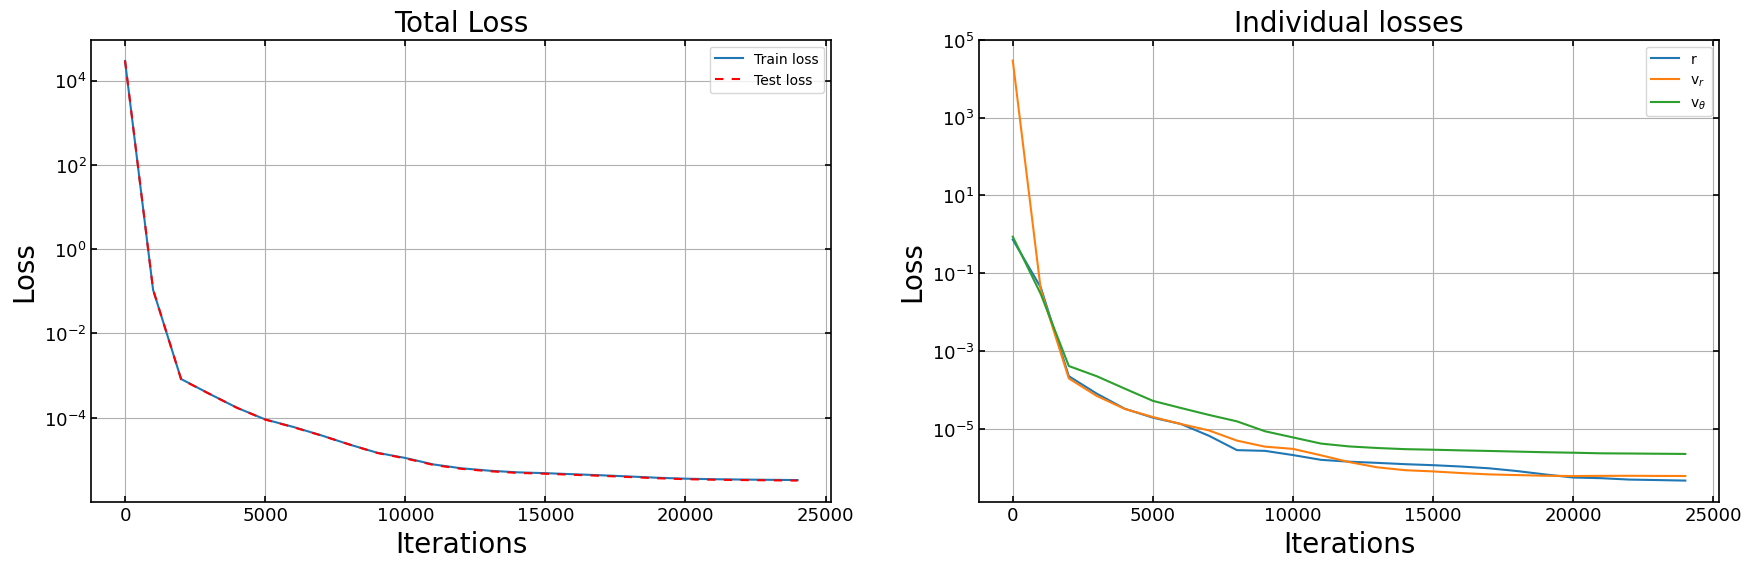

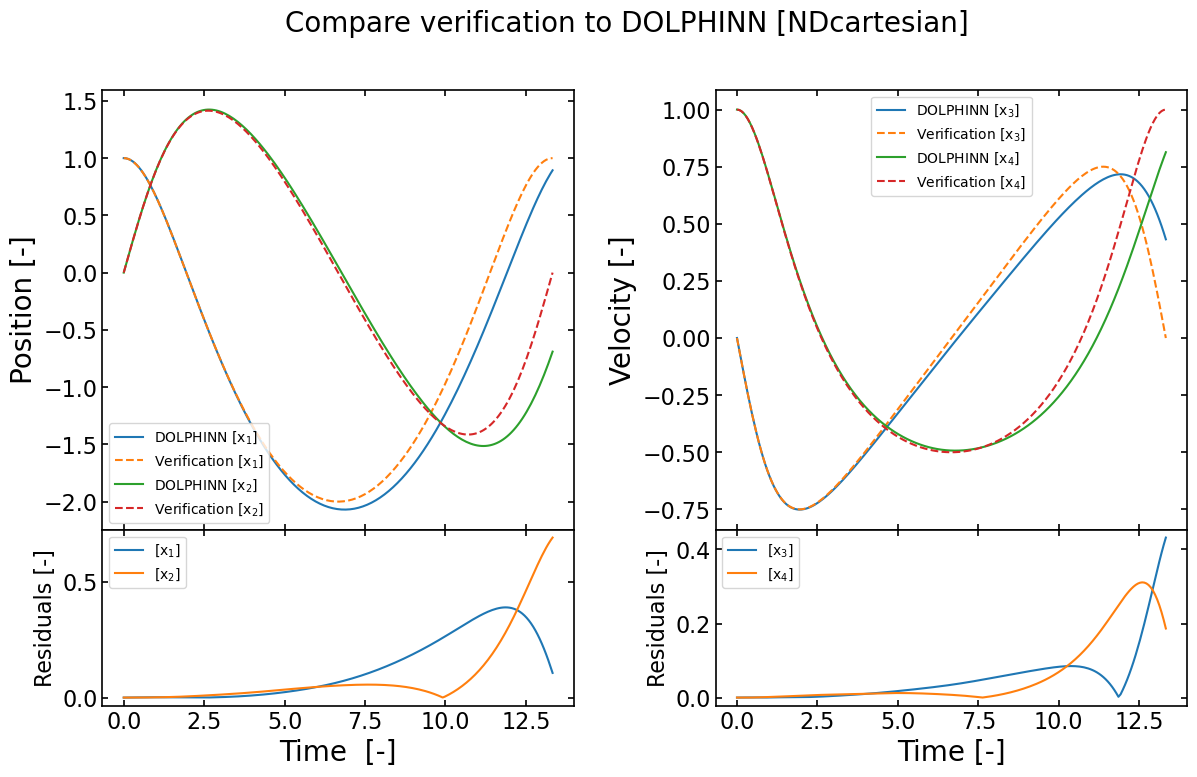

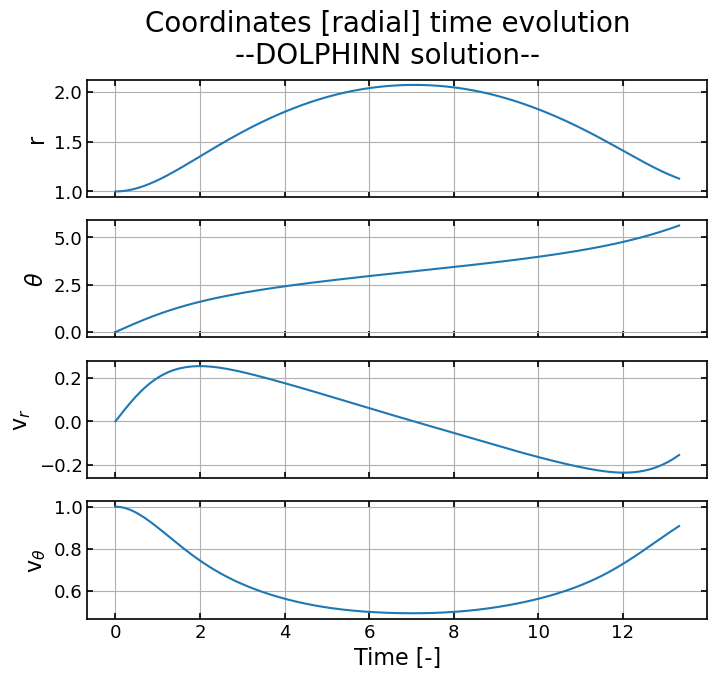

In [56]:
problem.verify()
plotting.plot_loss(problem, objective_zoom=False)  
plotting.compare(problem, 'NDcartesian', log = False)
plotting.plot_coordinates(problem, "radial", plot_control = False)

In [29]:
problem.store("../Data/Integration/radial/case1/", overwrite = True)

Saving loss history to ../Data/Integration/radial/case1/loss.dat ...
Saving training data to ../Data/Integration/radial/case1/train.dat ...
Saving test data to ../Data/Integration/radial/case1/test.dat ...
[DOLPHINN] Saving config file to ../Data/Integration/radial/case1/config
